In [2]:
def write_swinput(SZA, aero_tau,swoutfile, surf_albedo, day_of_year):
    swfname = open('swinput1', 'w')
    swfname.write(
        'atmosphere_file /data/keeling/a/yulanh/c/software_install/libradtran/2.0.2/share/libRadtran/data/atmmod/afglt.dat \n')
    swfname.write(
        'source solar /data/keeling/a/yulanh/c/software_install/libradtran/2.0.2/share/libRadtran/data/solar_flux/kurudz_1.0nm.dat \n')
    swfname.write('wavelength 250 4000\n')
    swfname.write('mol_abs_param fu\n')
    swfname.write('radiosonde atm_file_ecmwf.dat H2O MMR O3 MMR\n')
    swfname.write('rte_solver twostr\n')
    # swfname.write('sur_temperature '+str(surf_temp)+'\n')
    swfname.write('sza '+str(SZA[0])+'\n')

    if (aero_tau > 0):
        swfname.write('aerosol_default\n')
        #swfname.write('aerosol_species_library OPAC\n')
        swfname.write('aerosol_file tau aero_ext.dat\n')
        swfname.write('aerosol_file ssa aero_ssa.dat\n')
        swfname.write('aerosol_file gg aero_gg.dat\n')

    swfname.write('albedo '+str(surf_albedo[0])+' \n')
    #swfname.write('albedo_file albedo_file.dat \n')
    swfname.write('day_of_year '+str(day_of_year) +
                  '\n')  # 265 for 9.21, 260 for 9.16
    swfname.write('zout TOA\n')
    #swfname.write('zout '+str(float(flight_alt))+'\n')
    swfname.write('output_user eglo eup \n')
    swfname.write('output_process sum\n')
    swfname.write('output_file  ' + swoutfile+'\n')
    swfname.write('quiet\n')
    swfname.close()
    

def search_cldsatfile(initial_time,day_of_year):
    cldlon=[]
    cldlat=[]
    cldtime=[]
    FU=[]
    FU_NA=[]
    cldsat_fnames=sorted(glob.glob(cldsat_dir+year+str(day_of_year).zfill(3)+'*'))
    Ncldsat=len(cldsat_fnames)
    if (Ncldsat > 0):
        cldsat_initial_time=np.zeros((Ncldsat),'f')
        for fi in np.arange(Ncldsat):
            cldsat_initial_time[fi]=float(cldsat_fnames[fi][-57:-55])+\
            float(cldsat_fnames[fi][-55:-53])/60.0+float(cldsat_fnames[fi][-53:-51])/3600.0
        
        timediff=abs(initial_time-cldsat_initial_time)
        fileloc=np.argmin(timediff)
        
        cldsat_fname=cldsat_fnames[fileloc]
        cldsat_initial_time1=cldsat_initial_time[fileloc]  
        
        #== read cloudsat data ===
        # 2c-ice
        swath_name=cldsat_fname[-64:-45]
        c2ice_fname=glob.glob('/data/keeling/a/yulanh/c/BW_backup/CloudSat/2C-ICE/2008/'+swath_name+'*')[0]
        # ecmwf-aux
        ecmwf_fname=glob.glob('/data/keeling/a/yulanh/c/BW_backup/CloudSat/ECMWF/'+swath_name+'*')[0]
        cwc_fname=glob.glob('/data/keeling/a/yulanh/c/BW_backup/CloudSat/2B-CWC/2008/'+swath_name+'*')[0]
        #print('frist match',cldsat_fname)
        
        #== read cloudsat data ===
        f=HDF(c2ice_fname,SDC.READ)
        vs=f.vstart()
        c2ice_od=vs.attach('optical_depth')
        c2ice_cod=np.array(c2ice_od[:])
        c2ice_od.detach()
        f.close()
        
        hdf=SD(cwc_fname,SDC.READ)
        ro_iwc=hdf.select('RO_ice_water_content')[:]/1000.0
        ro_ire=hdf.select('RO_ice_effective_radius')[:]/1000000.0 # m # density 917000 g/m3
        ro_cwcod=1.5*ro_iwc/(ro_ire*917000)
        ro_cwcod=np.nansum(ro_cwcod*240,axis=1)
        f=HDF(cwc_fname,SDC.READ)
        vs=f.vstart()
        ro_lwp=vs.attach('RO_liq_water_path')
        ro_lwp1=np.array(ro_lwp[:])
        ro_lwp.detach()
        f.close()
        
        
        hdf=SD(ecmwf_fname,SDC.READ)
        ecmwf_t=hdf.select('Temperature')[:]
        ecmwf_sp=hdf.select('Specific_humidity')[:]
        ecmwf_o3=hdf.select('Ozone')[:]
        ecmwf_p=hdf.select('Pressure')[:]/100.0
        
        f=HDF(cldsat_fname,SDC.READ)
        vs=f.vstart()
        atcldlat=vs.attach('Latitude')
        cldlat=np.array(atcldlat[:])
        atcldlon=vs.attach('Longitude')
        cldlon=np.array(atcldlon[:])
        atcldtime=vs.attach('Profile_time')
        cldtime=np.array(atcldtime[:])/3600.0+cldsat_initial_time1
        ind=np.where(cldtime >=24)[0]
        cldtime[ind]=cldtime[ind]-24
        atFD = vs.attach('FD_TOA_IncomingSolar')
        FD = np.array(atFD[:])/10.0
        scene_st=vs.attach('Scene_status')
        scene_status=np.array(scene_st[:])
        cldalbedo1 = vs.attach('Albedo')
        cldalbedo = np.array(cldalbedo1[:])
        
        cldalbedo1.detach()
        scene_st.detach()
        atFD.detach()
        atcldlat.detach()
        atcldlon.detach()
        atcldtime.detach()
        f.close()
        hdf=SD(cldsat_fname,SDC.READ)
        FU = hdf.select('FU_TOA')[:]/10.0
        FU_NA = hdf.select('FU_NA_TOA')[:]/10.0
        TOACRE = hdf.select('TOACRE')[:]
            
    #print('rematch',cldsat_initial_time,cldsat_fname)        
    return cldlon,cldlat,cldtime,FU,FU_NA,TOACRE,scene_status,cldalbedo,c2ice_od,ecmwf_t,ecmwf_sp,ecmwf_o3,\
        ecmwf_p,ro_cwcod,ro_lwp1
    
    
def vfm_feature_flag(val):
    feature_type=0
    feature_type_qa = 0
    ice_water_phase = 0
    ice_water_phase_qa = 0
    feature_subtype = 0
    cloud_aerosol_psc_type_qa = 0
    horizontal_averaging = 0
    aerotyp_flag=0
    
    for bi in np.arange(16):
        if (val%2 != 0):
            #print('bit ',bi+1)
        
            if (bi+1 == 1):
                feature_type=feature_type+1
            elif (bi+1 == 2):
                feature_type=feature_type+2
            elif (bi+1 == 3):
                feature_type=feature_type+4
            elif (bi+1 == 4): 
                feature_type_qa=feature_type_qa+1
            elif (bi+1 == 5):
                feature_type_qa=feature_type_qa+2  
            elif (bi+1 == 6):
                ice_water_phase=ice_water_phase+1
            elif (bi+1 == 7): 
                ice_water_phase=ice_water_phase+2
            elif (bi+1 == 8):
                ice_water_phase_qa=ice_water_phase_qa+1
            elif (bi+1 == 9):
                ice_water_phase_qa=ice_water_phase_qa+2
            elif (bi+1 == 10):
                feature_subtype = feature_subtype+1
            elif (bi+1 == 11):
                feature_subtype = feature_subtype+2
            elif (bi+1 == 12):
                feature_subtype = feature_subtype+4
            elif (bi+1 == 13):
                cloud_aerosol_psc_type_qa = cloud_aerosol_psc_type_qa + 1
            elif (bi+1 == 14):
                horizontal_averaging = horizontal_averaging + 1
            elif (bi+1 == 15):
                horizontal_averaging = horizontal_averaging + 2
            else:
                horizontal_averaging = horizontal_averaging + 4
        val=int(val/2)
    return feature_type, feature_subtype, ice_water_phase   
                         
def read_text(fname):
    fo=open(fname,'r') #create file object
    #headstr=fo.readline()
    data=fo.readlines()
    #print (data)
    fo.close()  # close object
    return data
    
# this script is to colocate CALIPSO and 2B-FLXHR-LIDAR data to obtain cirrus impact on aerosol DRE
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import numpy as np
import math
from pyhdf.SD import SD, SDC
from pyhdf.HDF import *
from pyhdf.VS import *
import h5py
import glob
import os

print('start', datetime.now())

year='2008'

cldsat_dir='/data/keeling/a/yulanh/c/BW_backup/CloudSat/2B-FLXHR-LIDAR/'+year+'/'
fnames=sorted(glob.glob('/data/gdi/f/yulanh/CALIPSO/MLay/'+year+'/'+'CAL_LID_L2_05kmMLay-Standard-V4-20.2008-07*'))

#fnames=['/data/gdi/f/yulanh/CALIPSO/MLay/2007/CAL_LID_L2_05kmMLay-Standard-V4-20.2007-01-01T11-02-31ZD.hdf']

for fname in fnames[0:30]:   
    
    # === get the julday ===
    month=fname[-20:-18]
    day = fname[-17:-15]
    initial_hh= int(fname[-14:-12])
    initial_mm= int(fname[-11:-9])
    initial_time=initial_hh+initial_mm/60.0
    day_of_year=date(int(year),int(month),int(day)).timetuple().tm_yday
    
    dnflag=fname[-6:-4]
        
    cldsat_fnames=sorted(glob.glob(cldsat_dir+year+str(day_of_year).zfill(3)+'*'))
    Ncldsat=len(cldsat_fnames)
    #===get inital time for each cloudsat fname ===
    if ((Ncldsat > 0) & (dnflag == 'ZD')):
        cldsat_initial_time=np.zeros((Ncldsat),'f')
        for fi in np.arange(Ncldsat):
            cldsat_initial_time[fi]=float(cldsat_fnames[fi][-57:-55])+\
                float(cldsat_fnames[fi][-55:-53])/60.0+float(cldsat_fnames[fi][-53:-51])/3600.0
        
        timediff=abs(initial_time-cldsat_initial_time)
        fileloc=np.argmin(timediff)
        
        cldsat_fname=cldsat_fnames[fileloc]
        cldsat_initial_time1=cldsat_initial_time[fileloc]
        
        if (initial_time < cldsat_initial_time[fileloc]):
            cldsat_fname=cldsat_fnames[fileloc-1]
            cldsat_initial_time1=cldsat_initial_time[fileloc-1]
       
        # 2c-ice
        swath_name=cldsat_fname[-64:-45]
        c2ice_fname=glob.glob('/data/keeling/a/yulanh/c/BW_backup/CloudSat/2C-ICE/2008/'+swath_name+'*')[0]
        # ecmwf-aux
        ecmwf_fname=glob.glob('/data/keeling/a/yulanh/c/BW_backup/CloudSat/ECMWF/'+swath_name+'*')[0]
        
        #cwc-ro
        cwc_fname=glob.glob('/data/keeling/a/yulanh/c/BW_backup/CloudSat/2B-CWC/2008/'+swath_name+'*')[0]

        #print('frist match',cldsat_fname)
        
        #== read cloudsat data ===
        f=HDF(c2ice_fname,SDC.READ)
        vs=f.vstart()
        c2ice_od=vs.attach('optical_depth')
        c2ice_cod=np.array(c2ice_od[:])
        c2ice_od.detach()
        f.close()
        
        hdf=SD(cwc_fname,SDC.READ)
        ro_iwc=hdf.select('RO_ice_water_content')[:]/1000.0
        ro_ire=hdf.select('RO_ice_effective_radius')[:]/1000000.0 # m # density 917000 g/m3
        ro_cwcod=1.5*ro_iwc/(ro_ire*917000)
        ro_cwcod=np.nansum(ro_cwcod*240,axis=1)
        f=HDF(cwc_fname,SDC.READ)
        vs=f.vstart()
        ro_lwp=vs.attach('RO_liq_water_path')
        ro_lwp1=np.array(ro_lwp[:])
        ro_lwp.detach()
        f.close()
        
        hdf=SD(ecmwf_fname,SDC.READ)
        ecmwf_t=hdf.select('Temperature')[:]
        ecmwf_sp=hdf.select('Specific_humidity')[:]
        ecmwf_o3=hdf.select('Ozone')[:]
        ecmwf_p=hdf.select('Pressure')[:]/100.0
        
        f=HDF(cldsat_fname,SDC.READ)
        vs=f.vstart()
        atcldlat=vs.attach('Latitude')
        cldlat=np.array(atcldlat[:])
        atcldlon=vs.attach('Longitude')
        cldlon=np.array(atcldlon[:])
        atcldtime=vs.attach('Profile_time')
        cldtime=np.array(atcldtime[:])/3600.0+cldsat_initial_time1
        ind=np.where(cldtime >=24)[0]
        cldtime[ind]=cldtime[ind]-24
        atFD = vs.attach('FD_TOA_IncomingSolar')
        FD = np.array(atFD[:])/10.0
        cldalbedo1 = vs.attach('Albedo')
        cldalbedo = np.array(cldalbedo1[:])
        scene_st=vs.attach('Scene_status')
        scene_status=np.array(scene_st[:])
        scene_st.detach()
        cldalbedo1.detach()
        atFD.detach()
        atcldlat.detach()
        atcldlon.detach()
        atcldtime.detach()

        hdf=SD(cldsat_fname,SDC.READ)
        FU = hdf.select('FU_TOA')[:]/10.0
        FU_NA = hdf.select('FU_NA_TOA')[:]/10.0
        FU_NC = hdf.select('FU_NC_TOA')[:]/10.0
        TOACRE = hdf.select('TOACRE')[:]
    
        #==== read aerosol data ===
        hdf=SD(fname)
        lidlat=hdf.select('Latitude')
        lidlat=lidlat[:,:]
        lidlon=hdf.select('Longitude')
        lidlon=lidlon[:,:]
        lidtime=hdf.select('Profile_UTC_Time')[:,:]
        cad_score=hdf.select('CAD_Score')
        cad_score=cad_score[:,:]
        extinc_qc=hdf.select('ExtinctionQC_532')[:,:]
        feature_flag=hdf.select('Feature_Classification_Flags')[:,:]
        cod=hdf.select('Column_Optical_Depth_Cloud_532')[:]
        cod=cod.reshape(len(cod))
        aod=hdf.select('Column_Optical_Depth_Tropospheric_Aerosols_532')[:]
        aod=aod.reshape(len(aod))
        layer_top=hdf.select('Layer_Top_Altitude')[:,:]
        layer_base=hdf.select('Layer_Base_Altitude')[:,:]
        feature_od=hdf.select('Feature_Optical_Depth_532')[:,:]
        SZA = hdf.select('Solar_Zenith_Angle')[:]

        matchdata_flag=0 # used for mark if rematch the data
        #aodind=np.where(aod > 0)[0]
        #=== initialize writing ==================
        wfname='simulate_calipso_aerosol_radiation_'+fname[-25:-4]+'.h5'
        Ns=len(aod)
        calipso_cod=np.zeros((Ns),'f')
        wc2ice_cod = np.zeros((Ns),'f')
        wrocwc_od =np.zeros((Ns),'f')
        calipso_aod=np.zeros((Ns),'f')
        wsurf_albedo=np.zeros((Ns),'f')
        wflux_up = np.zeros((Ns),'f')
        wflux_na_up=np.zeros((Ns),'f')
        wsolar = np.zeros((Ns),'f')
        simulate_up = np.zeros((Ns),'f')
        simulate_na_up = np.zeros((Ns),'f')
        aero_cld_flag =np.zeros((Ns),'i') # 1 for aero-only, 2 for cirrus-aerosol
        
        for si in range(len(aod)):
            #print(si,aodind[si])
            tplidlat=lidlat[si,1]
            tplidlon=lidlon[si,1]
            tplidtime=(lidtime[si,1]-int(lidtime[si,1]))*24
            tpcad_score=cad_score[si,:]
            tpext = extinc_qc[si,:]
            tpcod = cod[si]
            tpaod = aod[si]
            tplaytop=layer_top[si,:]
            tplaybase=layer_base[si,:]
            tpfeature=feature_flag[si,:]
            tpfeature_od=feature_od[si,:]
            tpsza=SZA[si]
           
            tphour=int(tplidtime/3600)
            residual=((tplidtime/3600-tphour)*60)
            tpminute=int(residual)
            tpsecond=int((residual-tpminute)*60)

            # === get clear sky and below-cirrus aerosol flag === 
          
            altind=np.where((tplaytop > 0))[0]
            Nh=len(altind)
            lowcad_flag=0
            extqc_flag=0
            cirrus_flag=0
            liquid_flag=0
            cloud_flag=0
            aero_flag=0
            aero_topmost=0
            aero_baselow=0
            cirrus_baselow =0
            #print(tpcad_score,tplaybase,tplaytop,tpext,tpfeature)
            #=== write aerosol file ====
            ssa_fname=open('aero_ssa.dat','w')
            gg_fname =open('aero_gg.dat','w')
            ext_fname=open('aero_ext.dat','w')
            mean_ssa =0.0
            mean_gg =0.0
            Naero_lay=0
                       
            for hi in range(Nh-1,-1,-1):
                tplaybase_1=tplaybase[altind[hi]]
                tplaytop_1 = tplaytop[altind[hi]]
                #print('cadscore',tpcad_score[altind[hi]],lowcad_flag)
                
                if ((abs(tpcad_score[altind[hi]]) < 20) | (abs(tpcad_score[altind[hi]]) > 100)):
                    if (lowcad_flag == 0):
                        lowcad_flag=1
                   
                tpext_1=tpext[altind[hi]]
               
                if ((tpext_1 != 0) & (tpext_1 != 1) & (tpext_1 != 16) & (tpext_1 != 18)):
                    if (extqc_flag ==0):
                        extqc_flag=1
                #print('extqc',si,extqc_flag,tpext_1,tpext)
                if ((abs(tpcad_score[altind[hi]]) >= 20) & (abs(tpcad_score[altind[hi]]) <= 100) & (extqc_flag ==0)):
                    feature_type, feature_subtype,cloud_phase=vfm_feature_flag(tpfeature[altind[hi]])
                    # dealing with ice clouds
                    if ((cloud_phase == 1) | (cloud_phase == 3)):
                        cirrus_flag=1
                        if (cirrus_baselow ==0):
                            cirrus_baselow=tplaybase_1
                        if ((cirrus_baselow !=0) & (cirrus_baselow > tplaybase_1)):
                            cirrus_baselow=tplaybase_1
                            
                    if (cloud_phase ==2):
                        liquid_flag=1
                        
                    # dealing with aerosols
                    aero_ssa=0.0
                    aero_gg =0.0
                
                    if ((feature_type == 3) | (feature_type ==4)):
                        aero_flag=1
                        if (aero_topmost ==0):
                            aero_topmost=tplaytop_1
                        if ((aero_topmost != 0) & (aero_topmost < tplaytop_1)):
                            aero_topmost=tplaytop_1
                        if ((aero_baselow == 0) & (tplaybase_1 >0)):
                            aero_baselow=tplaybase_1
                        if ((aero_baselow !=0) & (aero_baselow > tplaybase_1) & (tplaybase_1 >0)):
                            aero_baselow=tplaybase_1
                            
                            #add ssa and g same as Tabl2 2 in 2B-FLXHR-LIDAR document
                            
                        if (feature_subtype == 1):
                            aero_ssa=0.96
                            aero_gg =0.77
                        elif (feature_subtype ==2):
                            aero_ssa=0.93
                            aero_gg=0.74
                        elif (feature_subtype==3):
                            aero_ssa=0.99
                            aero_gg=0.76
                        elif (feature_subtype==4):
                            aero_ssa=0.99
                            aero_gg=0.74
                        elif (feature_subtype==5):
                            aero_ssa=0.94
                            aero_gg = 0.70
                        elif (feature_subtype ==6):
                            aero_ssa=0.83
                            aero_gg=0.66
                        elif (feature_subtype ==7):
                            aero_ssa=0.94
                            aero_gg=0.71
                        else:
                            aero_ssa=0.95
                            aero_gg=0.70
                            
                        mean_ssa=mean_ssa+aero_ssa
                        mean_gg =mean_gg +aero_gg
                        Naero_lay=Naero_lay+1
                        
                    if (feature_type == 2):
                        cloud_flag=1
            
                #==write aerosol file ===
            if (aero_flag ==1):
                ext_fname.write('{} {} \n'.format(aero_topmost,0.0))
                ssa_fname.write('{} {} \n'.format(aero_topmost,0.0))
                gg_fname.write('{} {} \n'.format(aero_topmost,0.0))


                ext_fname.write('{} {} \n'.format(aero_baselow,tpaod))#/(1000*(tplaytop_1-tplaybase_1))))
                ssa_fname.write('{} {} \n'.format(aero_baselow,mean_ssa/Naero_lay))
                gg_fname.write('{} {} \n'.format(aero_baselow,mean_gg/Naero_lay))    

                ext_fname.close()
                ssa_fname.close()
                gg_fname.close()
            #=== end deal with high confidence aero and cloud ======
            #print(si,feature_subtype,feature_type,aero_flag,lowcad_flag,extqc_flag,cirrus_flag,liquid_flag,tpcod,tpaod)
            #print(si,tpcad_score,tplaytop,tplaybase,tpext,Naero_lay)
            # start dealing with aerosol only ====
            if ((aero_flag == 1) & (tpcod == 0) & (extqc_flag ==0) & (lowcad_flag ==0) & \
                (tpaod >0)):
                
                #=== match to cloudsat =====
                swath_locdiff=np.sqrt((tplidlon-cldlon)**2+(tplidlat-cldlat)**2)
                swath_loc=np.argmin(swath_locdiff)
                
               
                if ((swath_locdiff[swath_loc] > 0.035) & (matchdata_flag ==0)):
                    #print('not match',si,aodind[si],swath_locdiff[swath_loc],fname)
                    # read new file
                    lidyymmdd=str(int(lidtime[si,1]))
                    month=lidyymmdd[1:3]
                    day=lidyymmdd[3:5]
                    day_of_year=date(int(year),int(month),int(day)).timetuple().tm_yday
                    initial_time=(lidtime[si,1]-int(lidtime[si,1]))*24
                    cldlon,cldlat,cldtime,FU,FU_NA,TOACRE,scene_status,cldalbedo,c2ice_od,ecmwf_t,ecmwf_sp,ecmwf_o3,\
                    ecmwf_p,ro_cwcod,ro_lwp1= search_cldsatfile(initial_time,day_of_year)
                    matchdata_flag=1
                    swath_locdiff=np.sqrt((tplidlon-cldlon)**2+(tplidlat-cldlat)**2)
                    swath_loc=np.argmin(swath_locdiff)
                    #print('re match',si,day_of_year,initial_time,aodind[si],swath_locdiff[swath_loc],fname)
                    #print('not match',si,aodind[si],swath_locdiff[swath_loc],fname)
                
                #judge whether there are cloud 
                scene_status_flag=bin(scene_status[swath_loc][0]).replace("0b","")
                scene_status_flag=scene_status_flag.zfill(16)
                subpixel_cloud_flag=1
                
                if ((scene_status_flag[-2] == '0') & (scene_status_flag[-3] == '0') & (scene_status_flag[-4] == '0') & \
                    (scene_status_flag[-5] == '0') & (scene_status_flag[-6] == '0')):
                    subpixel_cloud_flag=0
                
                
                if ((swath_locdiff[swath_loc] <= 0.035) & (subpixel_cloud_flag==0) & (TOACRE[0, swath_loc] == 0)):
                    #print('aeroonly',si,tplidtime,cldtime[swath_loc],swath_locdiff[swath_loc], \
                    #  TOACRE[0, swath_loc],scene_status[swath_loc],bin(scene_status[swath_loc][0]),\
                    #      subpixel_cloud_flag,tpaod,ro_lwp1[swath_loc])
                    # write_atmospheric file
                    tpecmwf_p=ecmwf_p[swath_loc,:]
                    tpecmwf_t=ecmwf_t[swath_loc,:]
                    tpecmwf_sp=ecmwf_sp[swath_loc,:]
                    tpecmwf_o3=ecmwf_o3[swath_loc,:]
                    
                    ecmwf_ind=np.where((tpecmwf_sp > 0) & (tpecmwf_o3 > 0))[0]
                    dat=np.array([tpecmwf_p[ecmwf_ind],tpecmwf_t[ecmwf_ind],tpecmwf_sp[ecmwf_ind],tpecmwf_o3[ecmwf_ind]])
                    dat=dat.T
                    np.savetxt('atm_file_ecmwf.dat',dat,delimiter=' ')
                    #== write the script to run ===
                    write_swinput(tpsza,tpaod,'aero_swout.txt', cldalbedo[swath_loc], day_of_year)
                    os.system('uvspec <swinput1> test')
                    #=== read output
                    data=read_text('aero_swout.txt')
                    splitcol=data[0].split(' ')
                    simu_swout=np.zeros((2),'f')
                    k=0
                    for j in range(len(splitcol)):
                        if len(splitcol[j]) != 0 and splitcol[j] !='\n':
                            simu_swout[k]=float(splitcol[j])
                            k=k+1
                    
                    
                    calipso_aod[si] = tpaod
                    aero_cld_flag[si]=1
                    wsurf_albedo[si] = cldalbedo[swath_loc]
                    wflux_up[si] = FU[0,swath_loc]
                    wflux_na_up[si]=FU_NA[0,swath_loc]
                    simulate_up[si]=simu_swout[1]
                    wsolar[si] = FD[swath_loc]
                    #=== remove aerosol
                    write_swinput(tpsza,0.0,'noaero_swout.txt', cldalbedo[swath_loc], day_of_year)
                    os.system('uvspec <swinput1> test')
                    #=== read output
                    data=read_text('noaero_swout.txt')
                    splitcol=data[0].split(' ')
                    simu_swout=np.zeros((2),'f')
                    k=0
                    for j in range(len(splitcol)):
                        if len(splitcol[j]) != 0 and splitcol[j] !='\n':
                            simu_swout[k]=float(splitcol[j])
                            k=k+1
                    
                    simulate_na_up[si]=simu_swout[1]
                    
            #print('flag',si,extqc_flag,lowcad_flag,aero_flag,cirrus_flag,tpaod,tpcod,\
            #      swath_locdiff[swath_loc],feature_subtype,mean_ssa,mean_gg) 
            #print(si,tpcad_score)
            
            if ((extqc_flag ==0) & (lowcad_flag ==0) & (aero_flag ==1) & (cirrus_flag ==1) & \
                (aero_topmost < cirrus_baselow) & (tpcod > 0) & (tpaod >0) & (liquid_flag ==0)):
                #print(si,tplidtime,cldtime[swath_loc],swath_locdiff[swath_loc], \
                #    TOACRE[0, swath_loc],scene_status[swath_loc],bin(scene_status[swath_loc][0]),\
                #        tpcod,c2ice_cod[swath_loc],ro_cwcod[swath_loc],ro_lwp1[swath_loc])
                #print(si,tpcod,tpaod,tpcad_score,tplaytop,tplaybase,tpext)
                #=== match to cloudsat =====
                swath_locdiff=np.sqrt((tplidlon-cldlon)**2+(tplidlat-cldlat)**2)
                swath_loc=np.argmin(swath_locdiff)
             
                if ((swath_locdiff[swath_loc] > 0.035) & (matchdata_flag==0)):
                    lidyymmdd=str(int(lidtime[si,1]))
                    month=lidyymmdd[1:3]
                    day=lidyymmdd[3:5]
                    day_of_year=date(int(year),int(month),int(day)).timetuple().tm_yday
                    initial_time=(lidtime[si,1]-int(lidtime[si,1]))*24
                    cldlon,cldlat,cldtime,FU,FU_NA,TOACRE,scene_status,cldalbedo,c2ice_od,ecmwf_t,ecmwf_sp,ecmwf_o3,\
                    ecmwf_p,ro_cwcod,ro_lwp1 = search_cldsatfile(initial_time,day_of_year)
                    matchdata_flag=1
                    swath_locdiff=np.sqrt((tplidlon-cldlon)**2+(tplidlat-cldlat)**2)
                    swath_loc=np.argmin(swath_locdiff)
               
          
                scene_status_flag=bin(scene_status[swath_loc][0]).replace("0b","")
                scene_status_flag=scene_status_flag.zfill(16)
                subpixel_cloud_flag=1
                
                if ((scene_status_flag[-3] == '0') & (scene_status_flag[-4] == '1') & (scene_status_flag[-5] == '0') & \
                    (scene_status_flag[-6] == '0')):
                    subpixel_cloud_flag=0
                if ((swath_locdiff[swath_loc] <= 0.035) & (subpixel_cloud_flag == 0) & (abs(TOACRE[0,swath_loc]) > 0) & \
                   (ro_lwp1[swath_loc] ==0)):
                    #print(TOACRE[0,swath_loc])
                    # write_atmospheric file
                    tpecmwf_p=ecmwf_p[swath_loc,:]
                    tpecmwf_t=ecmwf_t[swath_loc,:]
                    tpecmwf_sp=ecmwf_sp[swath_loc,:]
                    tpecmwf_o3=ecmwf_o3[swath_loc,:]
                    
                    ecmwf_ind=np.where(tpecmwf_sp >0)[0]
                    dat=np.array([tpecmwf_p[ecmwf_ind],tpecmwf_t[ecmwf_ind],tpecmwf_sp[ecmwf_ind],tpecmwf_o3[ecmwf_ind]])
                    dat=dat.T
                    np.savetxt('atm_file_ecmwf.dat',dat,delimiter=' ')
                    
                    #== write the script to run ===
                    write_swinput(tpsza,tpaod,'aero_swout.txt', cldalbedo[swath_loc], day_of_year)
                    os.system('uvspec <swinput1> test')
                    #=== read output
                    data=read_text('aero_swout.txt')
                    splitcol=data[0].split(' ')
                    simu_swout=np.zeros((2),'f')
                    k=0
                    for j in range(len(splitcol)):
                        if len(splitcol[j]) != 0 and splitcol[j] !='\n':
                            simu_swout[k]=float(splitcol[j])
                            k=k+1
                    
                    
                    calipso_aod[si] = tpaod
                    calipso_cod[si] = tpcod
                    wsurf_albedo[si] = cldalbedo[swath_loc]
                    wc2ice_cod  [si] =c2ice_cod[swath_loc]
                    wrocwc_od[si] = ro_cwcod[swath_loc]
                    aero_cld_flag[si]=2
                    wflux_up[si] = FU[0,swath_loc]
                    wflux_na_up[si]=FU_NA[0,swath_loc]
                    simulate_up[si]=simu_swout[1]
                    wsolar[si] = FD[swath_loc]
                    
                    #=== remove aerosol====
                    write_swinput(tpsza,0.0,'noaero_swout.txt', cldalbedo[swath_loc], day_of_year)
                    os.system('uvspec <swinput1> test')
                    #=== read output
                    data=read_text('noaero_swout.txt')
                    splitcol=data[0].split(' ')
                    simu_swout=np.zeros((2),'f')
                    k=0
                    for j in range(len(splitcol)):
                        if len(splitcol[j]) != 0 and splitcol[j] !='\n':
                            simu_swout[k]=float(splitcol[j])
                            k=k+1
                    
                    simulate_na_up[si]=simu_swout[1]
                    
                                  
                    
hf=h5py.File(wfname,'w')
hf.create_dataset('2cice_cod',data=wc2ice_cod)
hf.create_dataset('calipso_cod',data=calipso_cod)
hf.create_dataset('calipso_aod',data=calipso_aod)
hf.create_dataset('cloudsat_cwc_cod',data=wrocwc_od)
hf.create_dataset('surface_albedo',data=wsurf_albedo)
hf.create_dataset('aero_cirrus_flag',data= aero_cld_flag)
hf.create_dataset('cloudsat_uptoa',data=wflux_up)
hf.create_dataset('cloudsat_na_uptoa',data=wflux_na_up)
hf.create_dataset('cloudsat_incoming_solar',data=wsolar)
hf.create_dataset('simulation_uptoa',data=simulate_up)
hf.create_dataset('simulation_na_uptoa',data=simulate_na_up)
hf.close()

print('finish', datetime.now())

start 2022-09-20 11:11:38.281920


/tmp/ipykernel_213936/572200964.py:256: RuntimeWarning: invalid value encountered in true_divide
  ro_cwcod=1.5*ro_iwc/(ro_ire*917000)
/tmp/ipykernel_213936/572200964.py:74: RuntimeWarning: invalid value encountered in true_divide
  ro_cwcod=1.5*ro_iwc/(ro_ire*917000)

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/o


 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  t


 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  t


 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  t


 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  t

finish 2022-09-20 11:34:09.355243



 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors

 ******* ERROR >>>>>>  twostr_check_inputs--input and/or dimension errors


In [42]:
fnames=sorted(glob.glob('/data/gdi/f/yulanh/CALIPSO/MLay/2008/CAL_LID_L2_05kmMLay-Standard-V4-20.2008-07*'))
print(len(fnames))
#print(fname,fname[-25:-4])
print(cldsat_fname,cldsat_fname[-64:-45])

797
/data/keeling/a/yulanh/c/BW_backup/CloudSat/2B-FLXHR-LIDAR/2008/2008183012329_11573_CS_2B-FLXHR-LIDAR_GRANULE_P1_R05_E02_F00.hdf 2008183012329_11573


In [34]:
print(fname[-6:-4])

ZD


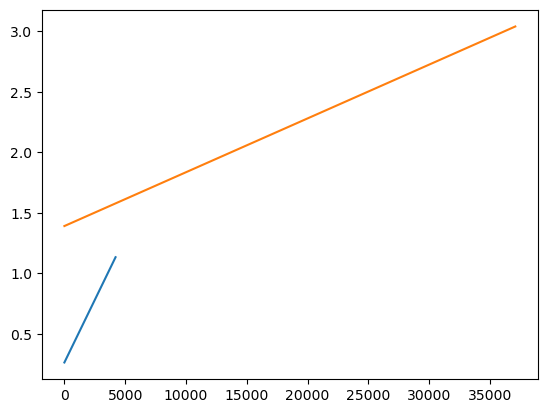

In [16]:
plt.plot((lidtime[:,1]-(lidtime[:,1].astype(int)))*24)
plt.plot(cldtime)